In [12]:
# Modelo Predictivo – Diabetes Dataset

# Este notebook demuestra paso a paso la creación de un modelo predictivo
# utilizando datos sintéticos basados en el dataset original de condiciones médicas.

# Objetivos:
# - Generar datos de entrenamiento realistas
# - Entrenar un modelo de clasificación
# - Visualizar resultados
# - Preparar datos para persistencia en PostgreSQL



In [13]:
# CELDA 1: imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

# Mostrar gráficos inline
%matplotlib inline
sns.set(style="whitegrid")


In [14]:
# CELDA 2: cargar CSV limpio
csv_path = "../data/cleaned/diabetes_cleaned.csv"  # ajustá ruta si hace falta
df = pd.read_csv(csv_path)
df.shape, df.columns.tolist()


((10000, 9),
 ['id',
  'full_name',
  'age',
  'gender',
  'smoking_status',
  'bmi',
  'blood_pressure',
  'glucose_levels',
  'condition'])

In [15]:
# CELDA 3: vista rápida
display(df.head())
df.info()
df.isnull().sum().sort_values(ascending=False)


,id,full_name,age,gender,smoking_status,bmi,blood_pressure,glucose_levels,condition
0,1,User0001,53,male,non-smoker,27.340637,134.832624,135.082933,Pneumonia
1,2,User0002,30,male,non-smoker,27.340637,105.315064,135.082933,Diabetic
2,3,User0003,18,male,non-smoker,35.612486,134.832624,135.082933,Pneumonia
3,4,User0004,53,male,non-smoker,27.340637,99.119829,135.082933,Pneumonia
4,5,User0005,76,male,non-smoker,27.340637,134.832624,135.082933,Diabetic


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   full_name       10000 non-null  object 
 2   age             10000 non-null  int64  
 3   gender          10000 non-null  object 
 4   smoking_status  10000 non-null  object 
 5   bmi             10000 non-null  float64
 6   blood_pressure  10000 non-null  float64
 7   glucose_levels  10000 non-null  float64
 8   condition       10000 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 703.3+ KB


id                0
full_name         0
age               0
gender            0
smoking_status    0
bmi               0
blood_pressure    0
glucose_levels    0
condition         0
dtype: int64

In [16]:
# CELDA 4: creamos copia y tratamos nulos de forma controlada
df_model = df.copy()  # evita SettingWithCopyWarning al editar

# columnas
num_cols = ['age', 'bmi', 'blood_pressure', 'glucose_levels']
cat_cols = ['gender', 'smoking_status']

# crear indicadores de missing (informativo)
for c in num_cols + cat_cols:
    df_model[f"{c}_missing"] = df_model[c].isnull().astype(int)

# imputación simple: mediana para numéricas, 'Unknown' para categóricas
num_imputer = SimpleImputer(strategy="median")
df_model[num_cols] = num_imputer.fit_transform(df_model[num_cols])

for c in cat_cols:
    df_model[c] = df_model[c].fillna("Unknown")

# revisar cambios
df_model[num_cols + cat_cols].head()


,age,bmi,blood_pressure,glucose_levels,gender,smoking_status
0,53.0,27.340637,134.832624,135.082933,male,non-smoker
1,30.0,27.340637,105.315064,135.082933,male,non-smoker
2,18.0,35.612486,134.832624,135.082933,male,non-smoker
3,53.0,27.340637,99.119829,135.082933,male,non-smoker
4,76.0,27.340637,134.832624,135.082933,male,non-smoker


In [17]:
# CELDA 5: preparar X e y
# 1) X: una versión con dummies (one-hot) para las categóricas (gender, smoking_status)
X = df_model.drop(columns=["id", "full_name", "condition"])  # id y full_name no se usan de features
X = pd.get_dummies(X, columns=cat_cols, drop_first=False)    # no perdemos info y evita strings

# 2) y: label encode de la variable target
y_raw = df_model["condition"].astype(str)  # aseguramos strings
le = LabelEncoder()
y = le.fit_transform(y_raw)  # 0,1,2... (guardamos mapping en `le`)

# Guardamos el mapping para reportes
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print("Label mapping:", label_mapping)

# Revisar shapes y tipos
print("X shape:", X.shape)
print("y shape:", y.shape)
display(X.head())


Label mapping: {np.int64(0): 'Cancer', np.int64(1): 'Diabetic', np.int64(2): 'Pneumonia'}
X shape: (10000, 14)
y shape: (10000,)


,age,bmi,blood_pressure,glucose_levels,age_missing,bmi_missing,blood_pressure_missing,glucose_levels_missing,gender_missing,smoking_status_missing,gender_female,gender_male,smoking_status_non-smoker,smoking_status_smoker
0,53.0,27.340637,134.832624,135.082933,0,0,0,0,0,0,False,True,True,False
1,30.0,27.340637,105.315064,135.082933,0,0,0,0,0,0,False,True,True,False
2,18.0,35.612486,134.832624,135.082933,0,0,0,0,0,0,False,True,True,False
3,53.0,27.340637,99.119829,135.082933,0,0,0,0,0,0,False,True,True,False
4,76.0,27.340637,134.832624,135.082933,0,0,0,0,0,0,False,True,True,False


In [18]:
# CELDA 6: dividir en train/test (siempre con random_state para reproducibilidad)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (7000, 14) Test: (3000, 14)


In [19]:
# CELDA 7: RandomizedSearch para optimizar precision_macro (puede cambiar a 'precision' o 'precision_weighted')
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": [None, "balanced"]
}

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,               # número de combinaciones a probar (ajustar)
    scoring="precision_macro",  # maximizar precision global (cambia si querés otra)
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
print("Mejor score (precision_macro):", search.best_score_)
print("Mejores parámetros:", search.best_params_)
best_model = search.best_estimator_


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Mejor score (precision_macro): 0.3529932503175928
Mejores parámetros: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': None}


In [22]:
# # CELDA 8: entrenar con el mejor estimador encontrado
# model = best_model  # ya está entrenado por RandomizedSearchCV; si querés reentrenar en todo el train+val, podés:
# # model.fit(X_train, y_train)

# # Guardar modelo a disco para uso futuro
# joblib.dump(model, "models/random_forest_best.joblib")
# print("Modelo guardado en models/random_forest_best.joblib")

# Si preferís guardar en una carpeta models dentro del mismo folder del notebook usa "models/..."
MODEL_PATH = os.path.join("..", "models", "random_forest_best.joblib")

# 2) Crear la carpeta si no existe
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

# 3) Guardar el modelo
joblib.dump(model, MODEL_PATH)

print(f"Modelo guardado correctamente en: {os.path.abspath(MODEL_PATH)}")

print("Current working dir:", os.getcwd())
print("Contenido de ../ (raíz del repo):", os.listdir(".."))
# comprobar si models ya existe
print("models existe?:", os.path.exists(os.path.join("..","models")))


Modelo guardado correctamente en: d:\Bootcamp 4.0\Data Analystic\Proyecto final\Repo\diabetes-analysis\models\random_forest_best.joblib
Current working dir: d:\Bootcamp 4.0\Data Analystic\Proyecto final\Repo\diabetes-analysis\etl
Contenido de ../ (raíz del repo): ['.env', '.git', '.gitignore', '.venv', 'data', 'docker-compose.yml', 'dw_load', 'etl', 'LICENSE', 'models', 'README.md', 'requirements.txt', 'venv']
models existe?: True


Classification report:
              precision    recall  f1-score   support

      Cancer       0.13      0.01      0.02       438
    Diabetic       0.60      0.90      0.72      1804
   Pneumonia       0.23      0.08      0.12       758

    accuracy                           0.56      3000
   macro avg       0.32      0.33      0.29      3000
weighted avg       0.44      0.56      0.47      3000



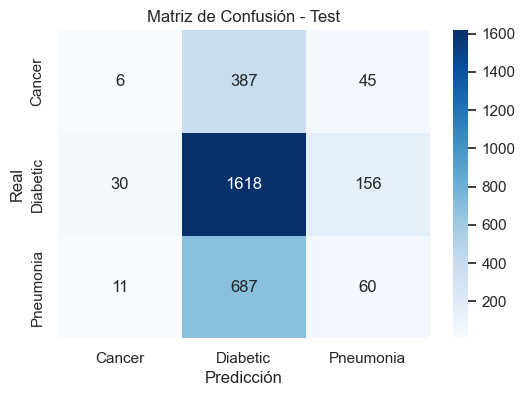

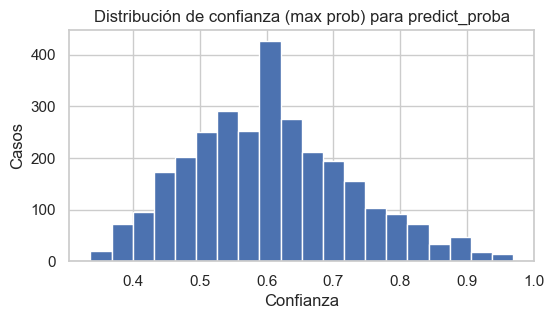

In [23]:
# CELDA 9: predecir y evaluar
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Test")
plt.show()

# Distribución de confianza máxima
plt.figure(figsize=(6,3))
plt.hist(y_proba.max(axis=1), bins=20)
plt.title("Distribución de confianza (max prob) para predict_proba")
plt.xlabel("Confianza")
plt.ylabel("Casos")
plt.show()


In [24]:
# CELDA 10: crear DataFrame con reales, predicciones y probabilidades (para inspección)
results = X_test.copy().reset_index(drop=True)
results["real_label"] = le.inverse_transform(y_test)
results["pred_label"] = le.inverse_transform(y_pred)
# agregar probabilidad de la clase predicha y vector de probabilidades
results["pred_prob"] = y_proba.max(axis=1)
# si querés guardar cada prob por clase:
proba_cols = [f"prob_{cls}" for cls in le.classes_]
proba_df = pd.DataFrame(y_proba, columns=proba_cols, index=results.index)
results = pd.concat([results, proba_df], axis=1)

display(results.head(10))


,age,bmi,blood_pressure,glucose_levels,age_missing,bmi_missing,blood_pressure_missing,glucose_levels_missing,gender_missing,smoking_status_missing,gender_female,gender_male,smoking_status_non-smoker,smoking_status_smoker,real_label,pred_label,pred_prob,prob_Cancer,prob_Diabetic,prob_Pneumonia
0,54.0,39.408063,111.000205,179.338547,0,0,0,0,0,0,True,False,True,False,Pneumonia,Diabetic,0.758956,0.123108,0.758956,0.117936
1,53.0,23.655437,134.832624,135.082933,0,0,0,0,0,0,False,True,True,False,Cancer,Diabetic,0.427896,0.255146,0.427896,0.316958
2,40.0,33.840723,134.832624,135.082933,0,0,0,0,0,0,False,True,True,False,Diabetic,Diabetic,0.491552,0.140255,0.491552,0.368193
3,85.0,36.910252,133.190685,137.296164,0,0,0,0,0,0,False,True,False,True,Diabetic,Diabetic,0.585699,0.102429,0.585699,0.311873
4,53.0,36.150155,134.832624,74.035004,0,0,0,0,0,0,False,True,True,False,Pneumonia,Diabetic,0.549707,0.105668,0.549707,0.344625
5,33.0,21.025628,118.075590,135.082933,0,0,0,0,0,0,False,True,True,False,Pneumonia,Diabetic,0.488051,0.143747,0.488051,0.368202
6,66.0,27.340637,134.832624,135.082933,0,0,0,0,0,0,False,True,True,False,Diabetic,Pneumonia,0.578240,0.034163,0.387597,0.578240
7,84.0,17.753320,134.832624,111.969015,0,0,0,0,0,0,False,True,True,False,Diabetic,Diabetic,0.594234,0.066536,0.594234,0.339230
8,63.0,27.340637,118.979576,125.751500,0,0,0,0,0,0,False,True,True,False,Diabetic,Diabetic,0.539092,0.198930,0.539092,0.261978
9,53.0,36.561272,134.832624,135.082933,0,0,0,0,0,0,False,True,True,False,Diabetic,Pneumonia,0.444995,0.135625,0.419380,0.444995


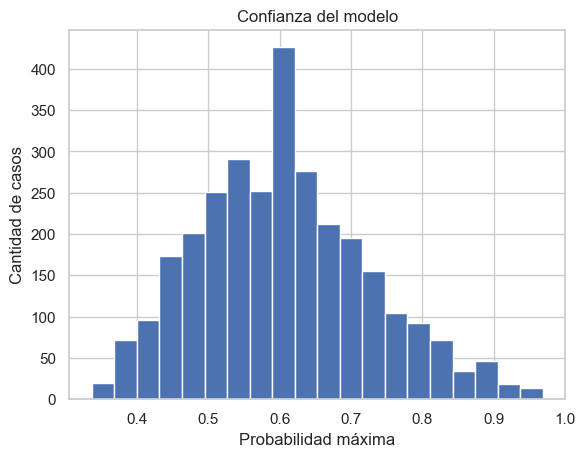

In [25]:
proba = model.predict_proba(X_test)

plt.hist(proba.max(axis=1), bins=20)
plt.title("Confianza del modelo")
plt.xlabel("Probabilidad máxima")
plt.ylabel("Cantidad de casos")
plt.show()
